In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/appa-real-face-cropped/labels.csv
/kaggle/input/appa-real-face-cropped/final_files/final_files/005463.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/000304.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/001940.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/007289.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/005491.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/001229.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/006258.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/000875.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/001989.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/001071.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/000780.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/001506.jpg
/kaggle/input/appa-real-face-cropped/final_files/final_files/003113.jpg
/kaggle/input/ap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import warnings
warnings.filterwarnings('ignore')



In [3]:
os.listdir('/kaggle/input')

labels = pd.read_csv('../input/appa-real-face-cropped/labels.csv')

In [4]:
# Откроем файл со значениями возраста
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# Проверим объем таблицы и формат данных
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В таблице 7591 строка, формат колонки `real_age` верный.

In [6]:
# Посмотрим на дубликаты
labels.duplicated().sum()

0

* Дубликатов нет.
* Построим график распределения возраста в выборке.

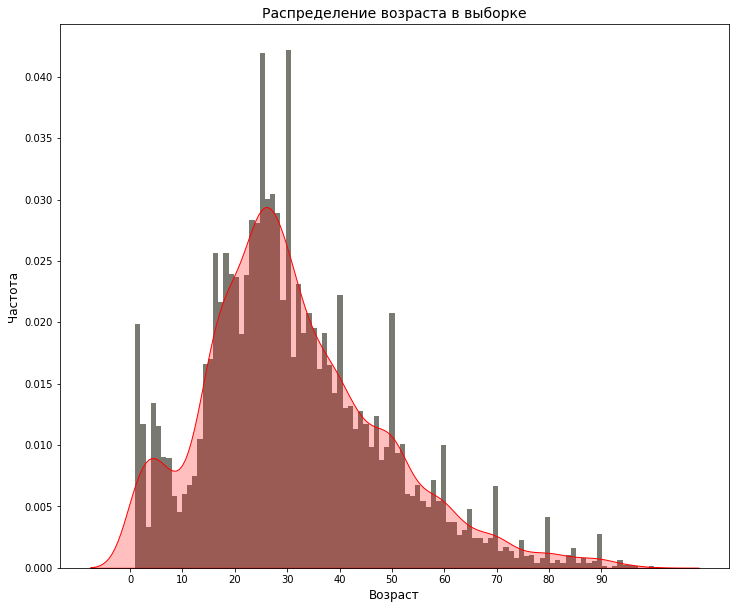

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [7]:
labels['real_age'].hist(bins=100, grid=False, figsize=(12,10), density=True)
plt.title('Распределение возраста в выборке', fontsize=14)
sns.distplot(labels['real_age'], rug=False, kde_kws={'shade':True, 'color':'r'}, bins=100)
plt.xlabel('Возраст', fontsize=12)
plt.xticks(np.arange(0, 100, step=10)) 
plt.ylabel('Частота', fontsize=12)
plt.show()
labels['real_age'].describe()

* В данных представлены самые разные возраста от 1 года до 100 лет.
* Медиана на 29 годах.
* Заметны пики для разных возрастных групп. Наибольшие значения в группах находятся у круглых дат, как 30,40,50 и т.д. Таким образом, большую часть возрастных категорий будут определяться вокруг круглых дат.
* Тем не менее, есть данные и вокруг круглых дат. 
* Данные выглядят правдоподобно.
* Однако значений около 90-100 лет крайне мало и возможно будет недостаточно для обучения модели.
* Далее импортируем данные с изображениями.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='../input/appa-real-face-cropped/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


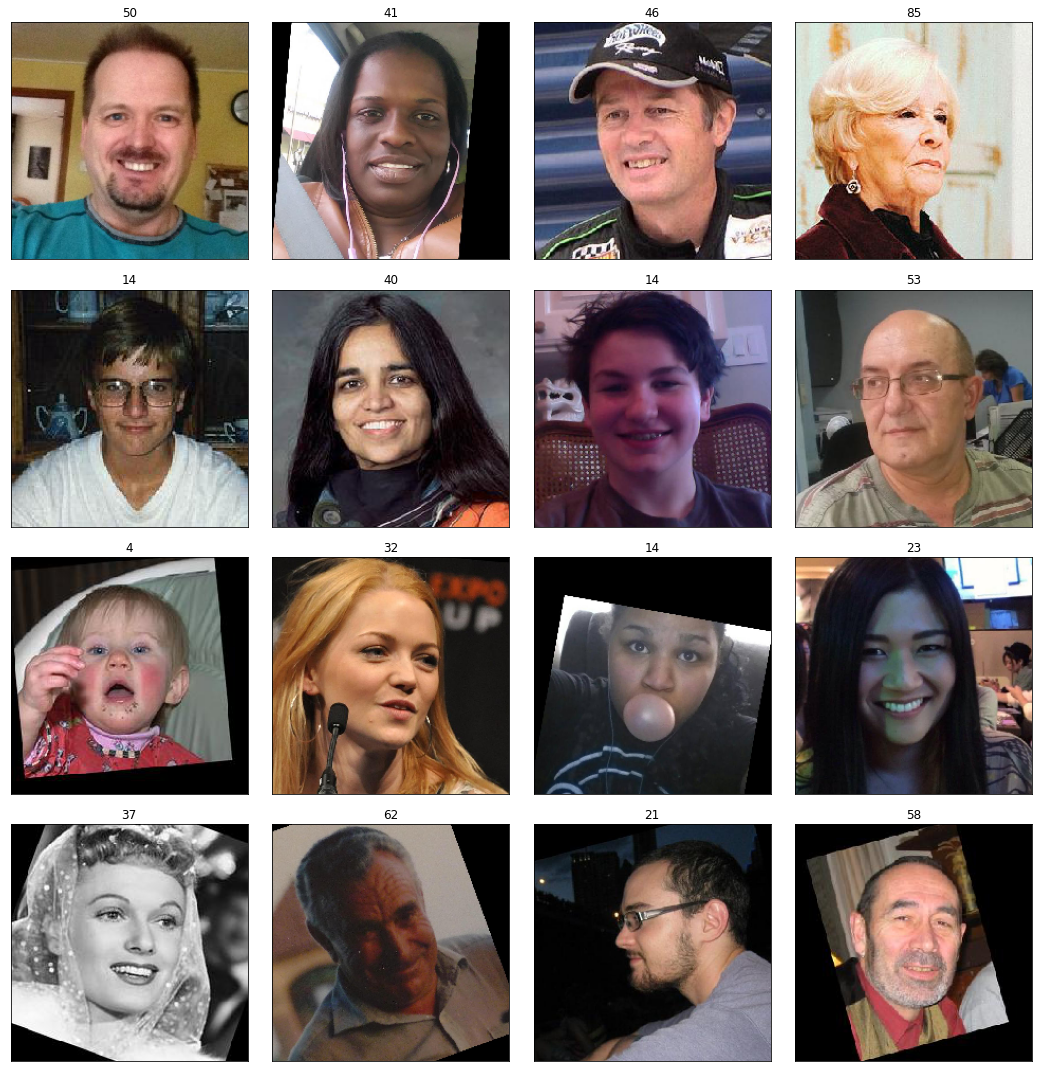

In [9]:
#Выведим значения изображений из первого батча тренировочной выборки
features, target = next(train_gen_flow)

# Выведем 16 рандомных изображений из первого батча тренировочной выборки
fig = plt.figure(figsize=(15,15))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
  # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

* Возрасты на рандомных 16 фото соответствуют изображениям.
* Представлены как цветные, так и чёрно-белые фото.
* Фото разного качества, некоторые фотографии имеют повернутый угол - центрированы.

## Построение и обучение модели

Построим функции для загрузки данных, построения и обучения модели.

In [10]:
# Загрузим данные тренировочного датасета
def load_train(path):
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True, # Добавим аугментацию
    vertical_flip=True)
  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='../input/appa-real-face-cropped/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return train_datagen_flow
 
# Загрузим данные тестового датасета
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='../input/appa-real-face-cropped/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return test_datagen_flow
 
# Построим модель
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
               metrics=['mae'])
    return model
 
# Построим функцию для обучения модели.
def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
 
    return model